In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt 
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import calendar
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("=== TAXI TRIP DURATION PREDICTION ANALYSIS ===")
print("Loading and preparing dataset...")

# Load the dataset from same folder
# Replace 'your_dataset.csv' with your actual filename
df_all = pd.read_csv('train.csv')  # Change this to your dataset filename
print(f'Dataset shape: {df_all.shape}')
print(f'Columns: {list(df_all.columns)}')


=== TAXI TRIP DURATION PREDICTION ANALYSIS ===
Loading and preparing dataset...
Dataset shape: (902843, 31)
Columns: ['Type', 'PROVIDER NAME', 'StartDateTime', 'DateCreated', 'ID', 'ExternalID', 'FareAmount', 'GratuityAmount', 'SurchargeAmount', 'ExtraFareAmount', 'TollAmount', 'TotalAmount', 'PaymentType', 'StartDateTime.1', 'EndDateTime', 'OriginStreetNumber', 'OriginStreetName', 'OriginCity', 'OriginState', 'OriginZip', 'OriginLatitude', 'OriginLongitude', 'DestinationStreetNumber', 'DestinationStreetName', 'DestinationCity', 'DestinationState', 'DestinationZip', 'DestinationLatitude', 'DestinationLongitude', 'Milage', 'Duration']


In [3]:
# ==========================================
# PART 1: DATA EXPLORATION
# ==========================================
print("\n" + "="*50)
print("PART 1: DATA EXPLORATION")
print("="*50)

# Distance calculation functions
def haversine_np(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points on earth"""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def distance_manhattan(lon1, lat1, lon2, lat2):
    a = haversine_np(lon1, lat1, lon2, lat1)
    b = haversine_np(lon1, lat1, lon1, lat2)
    return a + b

def bearing_array(lon1, lat1, lon2, lat2):
    lon_delta_rad = np.radians(lon2 - lon1)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))



PART 1: DATA EXPLORATION


In [4]:
# Check dataset structure and display info
print("Dataset Info:")
print(df_all.info())
print("\nFirst few rows:")
print(df_all.head())
print("\nBasic Statistics:")
print(df_all.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902843 entries, 0 to 902842
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Type                     902843 non-null  object 
 1   PROVIDER NAME            902842 non-null  object 
 2   StartDateTime            902842 non-null  object 
 3   DateCreated              902842 non-null  object 
 4   ID                       902842 non-null  object 
 5   ExternalID               902842 non-null  object 
 6   FareAmount               902839 non-null  float64
 7   GratuityAmount           902294 non-null  float64
 8   SurchargeAmount          902294 non-null  float64
 9   ExtraFareAmount          902294 non-null  float64
 10  TollAmount               902294 non-null  float64
 11  TotalAmount              902842 non-null  float64
 12  PaymentType              902842 non-null  float64
 13  StartDateTime.1          902842 non-null  obj

In [5]:
# Process datetime columns
df_all['StartDateTime'] = pd.to_datetime(df_all['StartDateTime'])
df_all['EndDateTime'] = pd.to_datetime(df_all['EndDateTime'])

# Calculate trip duration in seconds (our target variable)
df_all['trip_duration'] = (df_all['EndDateTime'] - df_all['StartDateTime']).dt.total_seconds()

# Extract datetime features
df_all['pickup_hour'] = df_all['StartDateTime'].dt.hour
df_all['pickup_day'] = df_all['StartDateTime'].dt.dayofweek
df_all['pickup_month'] = df_all['StartDateTime'].dt.month
df_all['pickup_weekday'] = (df_all['pickup_day'] < 5).astype(int)


In [6]:
# Calculate distances
print("Calculating distances...")
df_all['haversine_distance'] = haversine_np(
    df_all['OriginLongitude'], df_all['OriginLatitude'],
    df_all['DestinationLongitude'], df_all['DestinationLatitude']
)

df_all['manhattan_distance'] = distance_manhattan(
    df_all['OriginLongitude'], df_all['OriginLatitude'],
    df_all['DestinationLongitude'], df_all['DestinationLatitude']
)

df_all['bearing'] = bearing_array(
    df_all['OriginLongitude'], df_all['OriginLatitude'],
    df_all['DestinationLongitude'], df_all['DestinationLatitude']
)

Calculating distances...


In [7]:
# Calculate speed
df_all['avg_speed_h'] = 1000 * df_all['haversine_distance'] / df_all['trip_duration']

print("Basic statistics of trip duration:")
print(df_all['trip_duration'].describe())


Basic statistics of trip duration:
count    9.028420e+05
mean     8.180776e+02
std      2.986121e+03
min     -1.800000e+02
25%      4.200000e+02
50%      6.600000e+02
75%      9.940000e+02
max      2.592720e+06
Name: trip_duration, dtype: float64


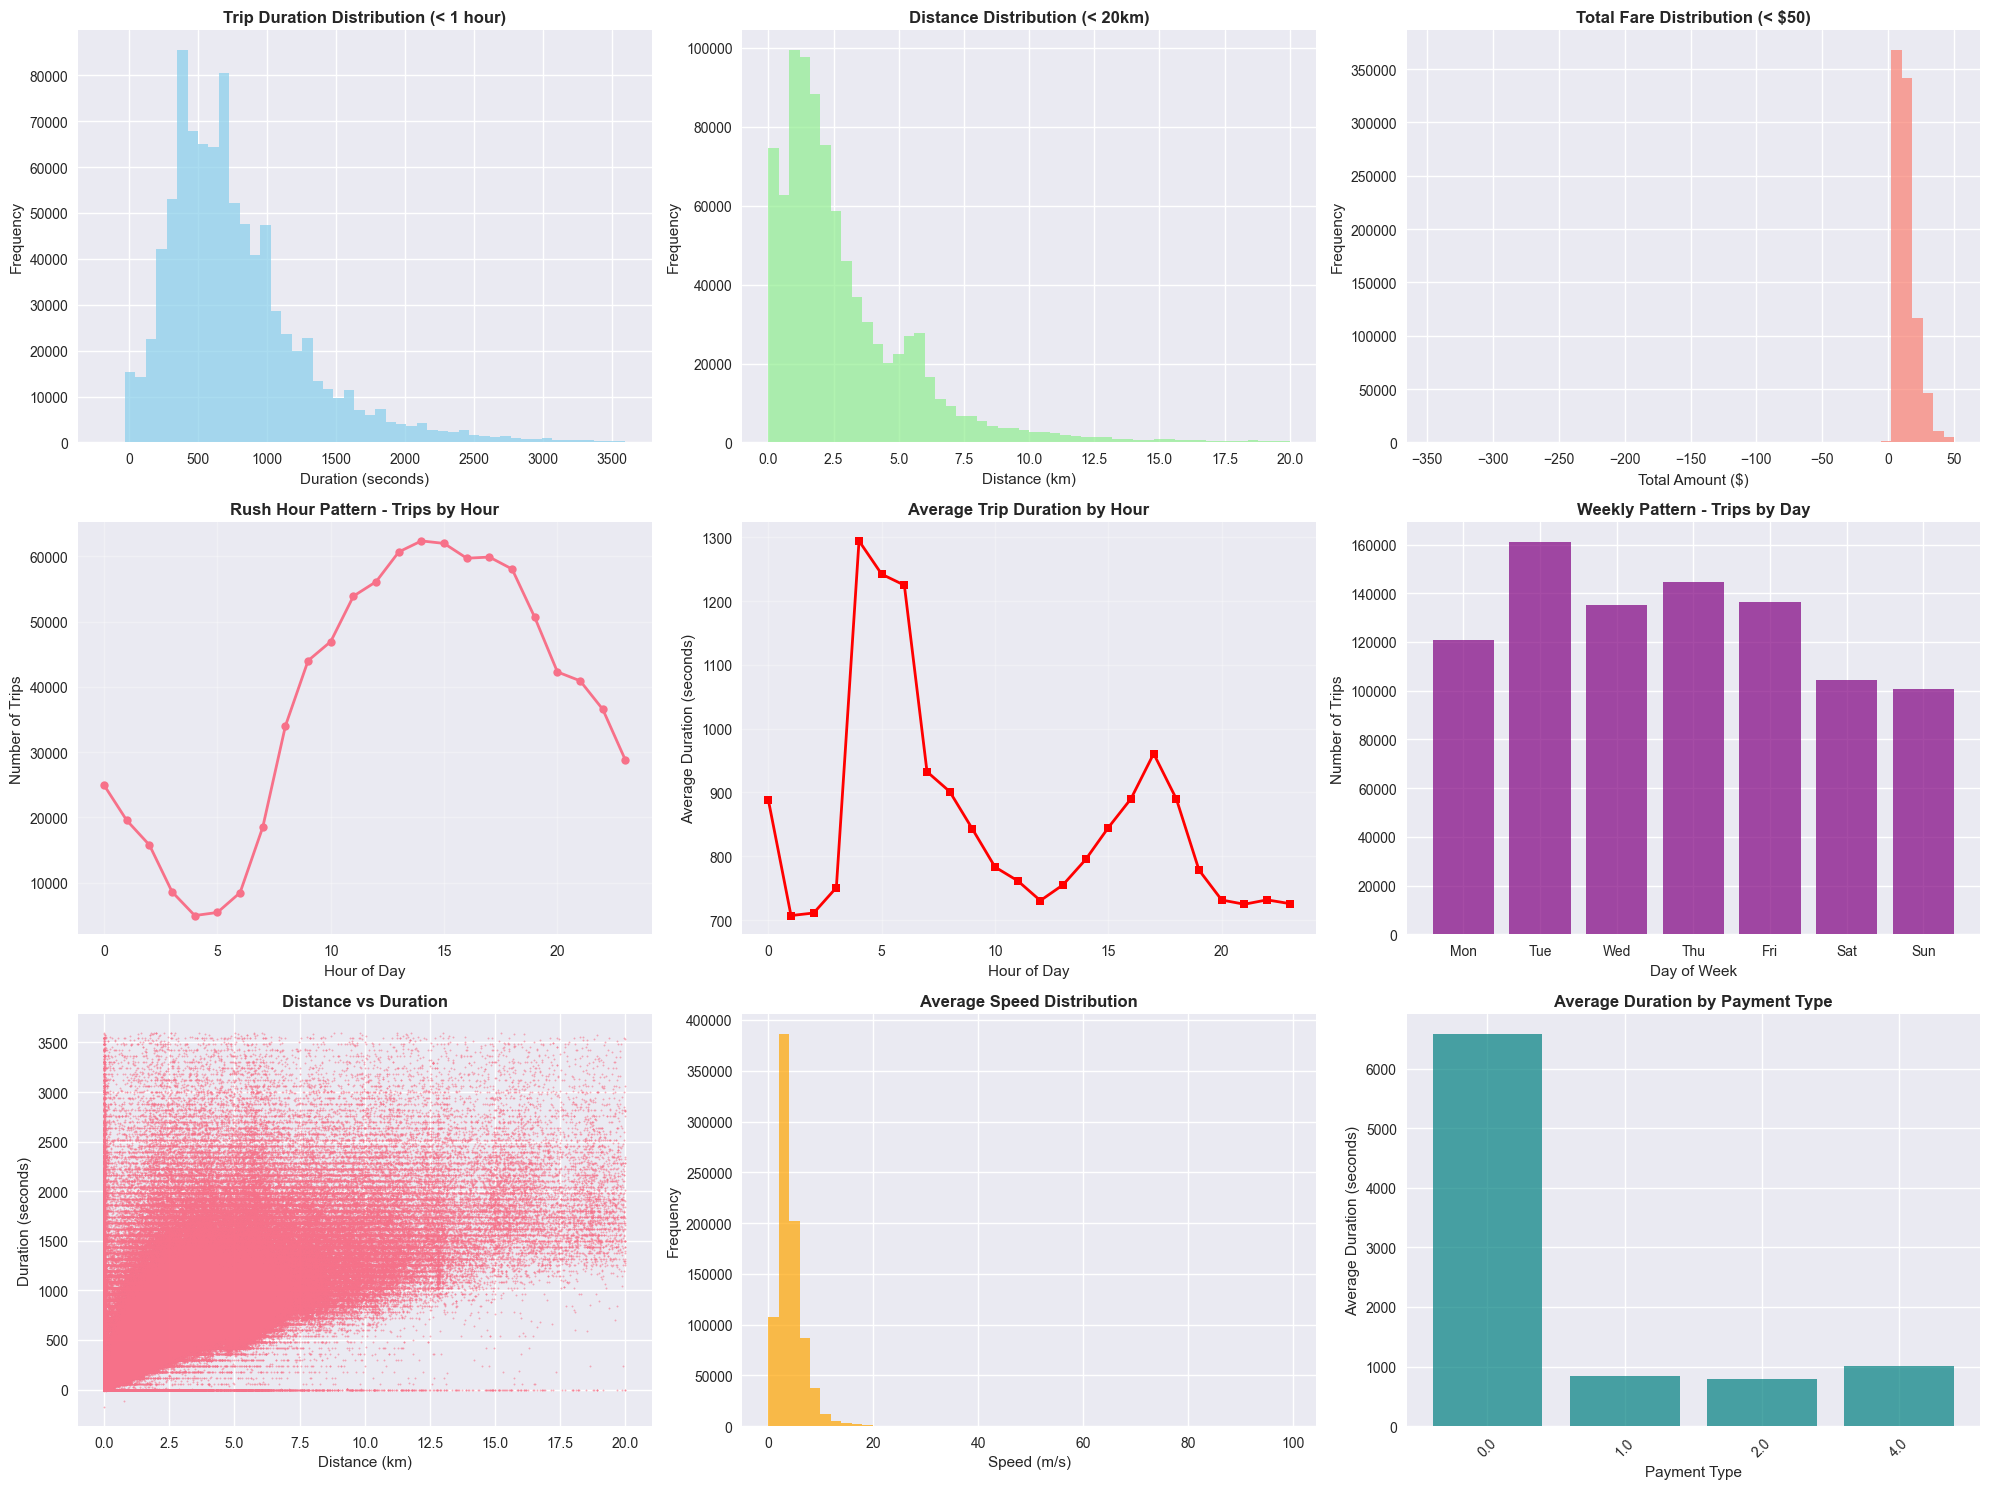

In [8]:

# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Plot 1: Trip duration distribution
axes[0,0].hist(df_all['trip_duration'][df_all['trip_duration'] < 3600], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Trip Duration Distribution (< 1 hour)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Duration (seconds)')
axes[0,0].set_ylabel('Frequency')

# Plot 2: Distance distribution
axes[0,1].hist(df_all['haversine_distance'][df_all['haversine_distance'] < 20], bins=50, alpha=0.7, color='lightgreen')
axes[0,1].set_title('Distance Distribution (< 20km)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Distance (km)')
axes[0,1].set_ylabel('Frequency')

# Plot 3: Fare distribution
axes[0,2].hist(df_all['TotalAmount'][df_all['TotalAmount'] < 50], bins=50, alpha=0.7, color='salmon')
axes[0,2].set_title('Total Fare Distribution (< $50)', fontsize=12, fontweight='bold')
axes[0,2].set_xlabel('Total Amount ($)')
axes[0,2].set_ylabel('Frequency')

# Plot 4: Rush hour analysis
hourly_trips = df_all.groupby('pickup_hour').size()
axes[1,0].plot(hourly_trips.index, hourly_trips.values, marker='o', linewidth=2, markersize=6)
axes[1,0].set_title('Rush Hour Pattern - Trips by Hour', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Number of Trips')
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Duration by hour
hourly_duration = df_all.groupby('pickup_hour')['trip_duration'].mean()
axes[1,1].plot(hourly_duration.index, hourly_duration.values, marker='s', color='red', linewidth=2, markersize=6)
axes[1,1].set_title('Average Trip Duration by Hour', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Average Duration (seconds)')
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Weekly pattern
daily_trips = df_all.groupby('pickup_day').size()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,2].bar(range(7), daily_trips.values, color='purple', alpha=0.7)
axes[1,2].set_title('Weekly Pattern - Trips by Day', fontsize=12, fontweight='bold')
axes[1,2].set_xlabel('Day of Week')
axes[1,2].set_ylabel('Number of Trips')
axes[1,2].set_xticks(range(7))
axes[1,2].set_xticklabels(day_names)

# Plot 7: Distance vs Duration scatter
mask = (df_all['haversine_distance'] < 20) & (df_all['trip_duration'] < 3600)
axes[2,0].scatter(df_all.loc[mask, 'haversine_distance'], 
                 df_all.loc[mask, 'trip_duration'], alpha=0.5, s=1)
axes[2,0].set_title('Distance vs Duration', fontsize=12, fontweight='bold')
axes[2,0].set_xlabel('Distance (km)')
axes[2,0].set_ylabel('Duration (seconds)')

# Plot 8: Speed distribution
axes[2,1].hist(df_all['avg_speed_h'][(df_all['avg_speed_h'] > 0) & (df_all['avg_speed_h'] < 100)], 
               bins=50, alpha=0.7, color='orange')
axes[2,1].set_title('Average Speed Distribution', fontsize=12, fontweight='bold')
axes[2,1].set_xlabel('Speed (m/s)')
axes[2,1].set_ylabel('Frequency')


# Plot 9: Payment type vs duration
payment_duration = df_all.groupby('PaymentType')['trip_duration'].mean()
axes[2,2].bar(range(len(payment_duration)), payment_duration.values, color='teal', alpha=0.7)
axes[2,2].set_title('Average Duration by Payment Type', fontsize=12, fontweight='bold')
axes[2,2].set_xlabel('Payment Type')
axes[2,2].set_ylabel('Average Duration (seconds)')
axes[2,2].set_xticks(range(len(payment_duration)))
axes[2,2].set_xticklabels(payment_duration.index, rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# ==========================================
# PART 2: CLUSTERING
# ==========================================
print("\n" + "="*50)
print("PART 2: CLUSTERING ANALYSIS")
print("="*50)

# Prepare coordinates for clustering
coords = np.vstack((df_all[['OriginLatitude', 'OriginLongitude']].values,
                   df_all[['DestinationLatitude', 'DestinationLongitude']].values))

# Remove any invalid coordinates
valid_coords_mask = ~np.isnan(coords).any(axis=1)
coords = coords[valid_coords_mask]

print(f"Valid coordinates for clustering: {len(coords)}")


PART 2: CLUSTERING ANALYSIS
Valid coordinates for clustering: 1803980


In [10]:
# Perform clustering (sample for efficiency if dataset is large)
if len(coords) > 500000:
    sample_ind = np.random.permutation(len(coords))[:500000]
    coords_sample = coords[sample_ind]
else:
    coords_sample = coords

kmeans = MiniBatchKMeans(n_clusters=100, random_state=42, batch_size=10000)
kmeans.fit(coords_sample)

print("Clustering completed!")

# Assign clusters to pickup and dropoff locations
df_all['pickup_cluster'] = kmeans.predict(df_all[['OriginLatitude', 'OriginLongitude']].fillna(0).values)
df_all['dropoff_cluster'] = kmeans.predict(df_all[['DestinationLatitude', 'DestinationLongitude']].fillna(0).values)

# Create cluster features
cluster_stats = df_all.groupby('pickup_cluster').agg({
    'trip_duration': ['mean', 'std'],
    'haversine_distance': 'mean',
    'TotalAmount': 'mean'
}).round(2)

cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]
cluster_stats = cluster_stats.add_prefix('pickup_cluster_')

df_all = df_all.merge(cluster_stats, left_on='pickup_cluster', right_index=True, how='left')


Clustering completed!


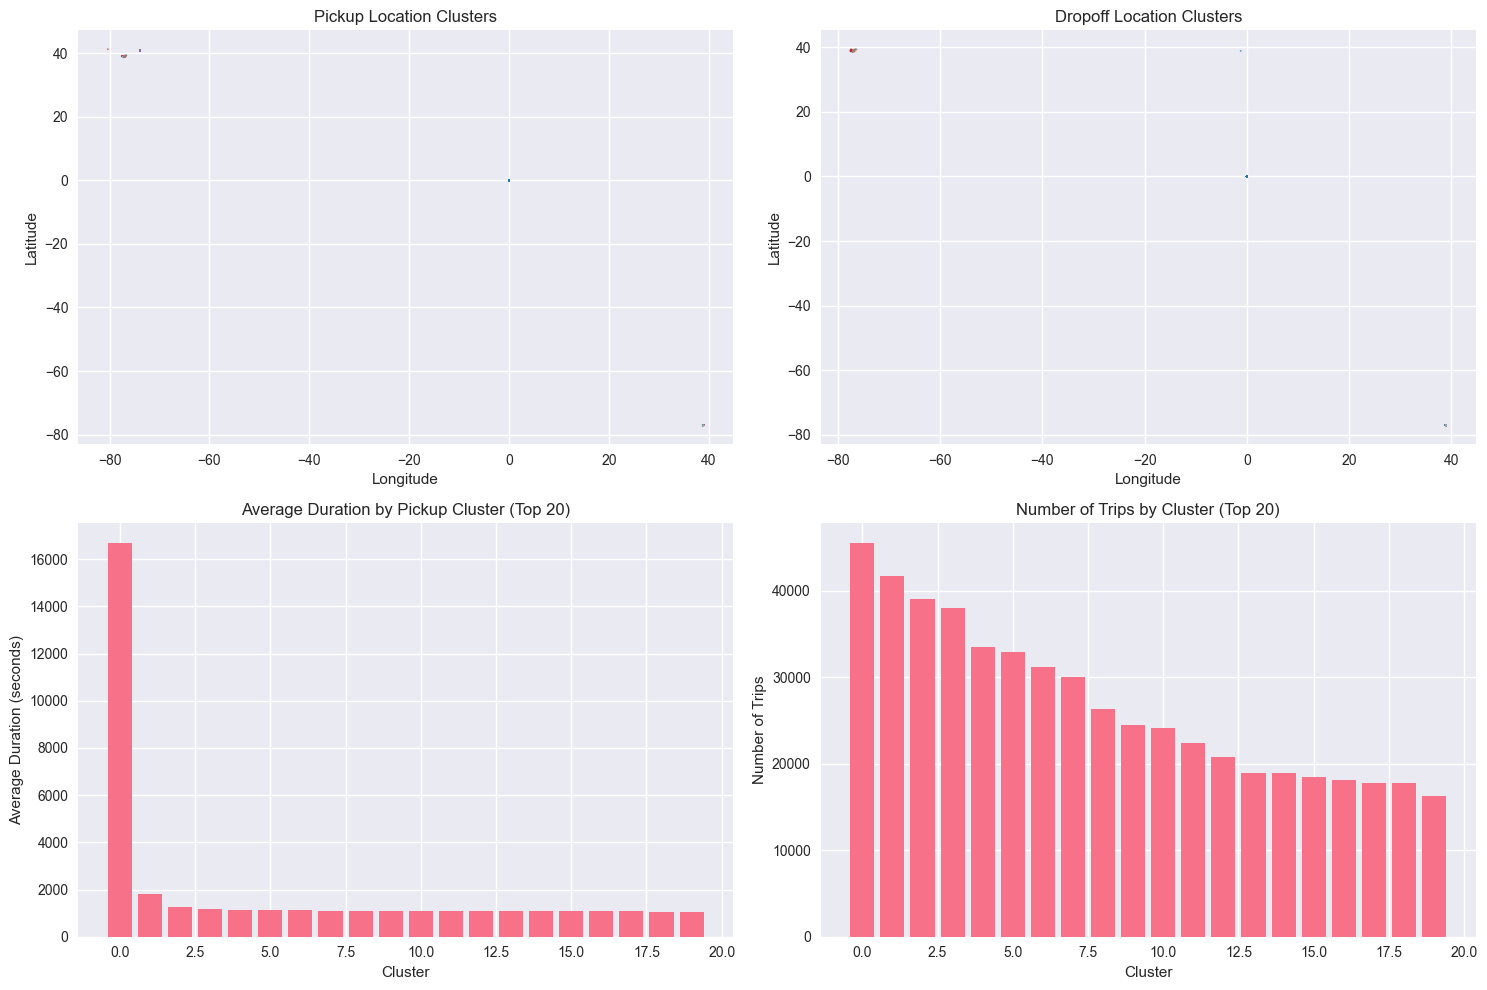

Created 100 clusters for pickup and dropoff locations


In [11]:

# Visualize clusters
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sample_size = min(50000, len(df_all))
sample_idx = np.random.choice(len(df_all), sample_size, replace=False)
plt.scatter(df_all.iloc[sample_idx]['OriginLongitude'], df_all.iloc[sample_idx]['OriginLatitude'], 
           c=df_all.iloc[sample_idx]['pickup_cluster'], cmap='tab20', s=1, alpha=0.6)
plt.title('Pickup Location Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2, 2, 2)
plt.scatter(df_all.iloc[sample_idx]['DestinationLongitude'], df_all.iloc[sample_idx]['DestinationLatitude'], 
           c=df_all.iloc[sample_idx]['dropoff_cluster'], cmap='tab20', s=1, alpha=0.6)
plt.title('Dropoff Location Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2, 2, 3)
cluster_duration = df_all.groupby('pickup_cluster')['trip_duration'].mean().sort_values(ascending=False)
plt.bar(range(min(20, len(cluster_duration))), cluster_duration[:20].values)
plt.title('Average Duration by Pickup Cluster (Top 20)')
plt.xlabel('Cluster')
plt.ylabel('Average Duration (seconds)')

plt.subplot(2, 2, 4)
cluster_count = df_all['pickup_cluster'].value_counts().sort_values(ascending=False)
plt.bar(range(min(20, len(cluster_count))), cluster_count[:20].values)
plt.title('Number of Trips by Cluster (Top 20)')
plt.xlabel('Cluster')
plt.ylabel('Number of Trips')

plt.tight_layout()
plt.show()

print(f"Created {kmeans.n_clusters} clusters for pickup and dropoff locations")



PART 3: DATA CLEANING AND FEATURE ENGINEERING
Identifying outliers...


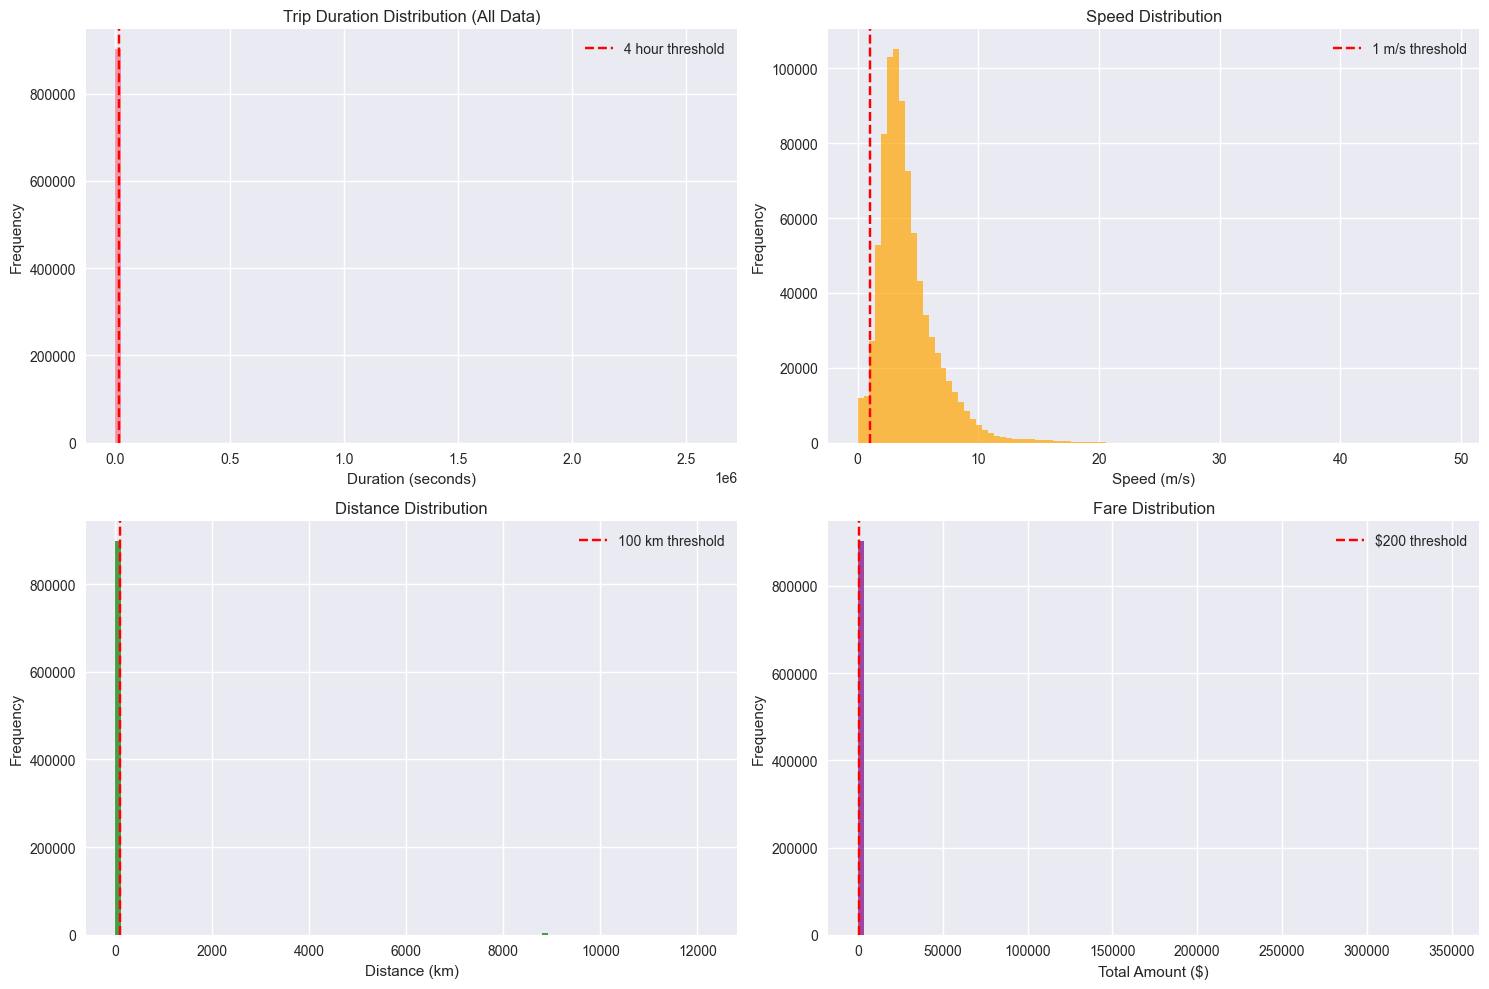

In [12]:
# ==========================================
# PART 3: CLEANING AND FEATURE SELECTION
# ==========================================
print("\n" + "="*50)
print("PART 3: DATA CLEANING AND FEATURE ENGINEERING")
print("="*50)

# Identify and visualize outliers
print("Identifying outliers...")

# Plot outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Duration outliers
axes[0,0].hist(df_all['trip_duration'], bins=100, alpha=0.7)
axes[0,0].set_title('Trip Duration Distribution (All Data)')
axes[0,0].set_xlabel('Duration (seconds)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(x=3600*4, color='red', linestyle='--', label='4 hour threshold')
axes[0,0].legend()

# Speed outliers
valid_speed = df_all['avg_speed_h'][(df_all['avg_speed_h'] > 0) & (df_all['avg_speed_h'] < 50)]
axes[0,1].hist(valid_speed, bins=100, alpha=0.7, color='orange')
axes[0,1].set_title('Speed Distribution')
axes[0,1].set_xlabel('Speed (m/s)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(x=1, color='red', linestyle='--', label='1 m/s threshold')
axes[0,1].legend()

# Distance outliers
axes[1,0].hist(df_all['haversine_distance'], bins=100, alpha=0.7, color='green')
axes[1,0].set_title('Distance Distribution')
axes[1,0].set_xlabel('Distance (km)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(x=100, color='red', linestyle='--', label='100 km threshold')
axes[1,0].legend()

# Fare outliers
axes[1,1].hist(df_all['TotalAmount'], bins=100, alpha=0.7, color='purple')
axes[1,1].set_title('Fare Distribution')
axes[1,1].set_xlabel('Total Amount ($)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(x=200, color='red', linestyle='--', label='$200 threshold')
axes[1,1].legend()


plt.tight_layout()
plt.show()

In [13]:

# Remove outliers
print("Original dataset size:", len(df_all))

# Remove unrealistic trips
df_clean = df_all[
    (df_all['trip_duration'] >= 60) &  # At least 1 minute
    (df_all['trip_duration'] <= 3600 * 4) &  # At most 4 hours
    (df_all['haversine_distance'] >= 0.1) &  # At least 100m
    (df_all['haversine_distance'] <= 100) &  # At most 100km
    (df_all['avg_speed_h'] >= 0.5) &  # At least 0.5 m/s
    (df_all['avg_speed_h'] <= 30) &  # At most 30 m/s (108 km/h)
    (df_all['TotalAmount'] >= 2.5) &  # Minimum fare
    (df_all['TotalAmount'] <= 200)  # Maximum reasonable fare
].copy()

print("Cleaned dataset size:", len(df_clean))
print(f"Removed {len(df_all) - len(df_clean)} outliers ({(len(df_all) - len(df_clean))/len(df_all)*100:.2f}%)")

# Feature engineering
print("\nCreating additional features...")

# Time-based features
df_clean['pickup_hour_sin'] = np.sin(2 * np.pi * df_clean['pickup_hour'] / 24)
df_clean['pickup_hour_cos'] = np.cos(2 * np.pi * df_clean['pickup_hour'] / 24)
df_clean['pickup_day_sin'] = np.sin(2 * np.pi * df_clean['pickup_day'] / 7)
df_clean['pickup_day_cos'] = np.cos(2 * np.pi * df_clean['pickup_day'] / 7)

# Location features
df_clean['center_latitude'] = (df_clean['OriginLatitude'] + df_clean['DestinationLatitude']) / 2
df_clean['center_longitude'] = (df_clean['OriginLongitude'] + df_clean['DestinationLongitude']) / 2

# Distance from city center (you can adjust these coordinates for your city)
# Using NYC coordinates as example - change to your city's center
city_center = (40.7589, -73.9851)  # Change this to your city's coordinates
df_clean['pickup_distance_to_center'] = haversine_np(
    df_clean['OriginLongitude'], df_clean['OriginLatitude'],
    city_center[1], city_center[0]
)
df_clean['dropoff_distance_to_center'] = haversine_np(
    df_clean['DestinationLongitude'], df_clean['DestinationLatitude'],
    city_center[1], city_center[0]
)

# PCA for rotation features
coords_pickup = df_clean[['OriginLatitude', 'OriginLongitude']].fillna(0).values
coords_dropoff = df_clean[['DestinationLatitude', 'DestinationLongitude']].fillna(0).values

pca = PCA(n_components=2)
coords_all_pca = pca.fit_transform(np.vstack([coords_pickup, coords_dropoff]))

n_samples = len(df_clean)
df_clean['pickup_pca1'] = coords_all_pca[:n_samples, 0]
df_clean['pickup_pca2'] = coords_all_pca[:n_samples, 1]
df_clean['dropoff_pca1'] = coords_all_pca[n_samples:, 0]
df_clean['dropoff_pca2'] = coords_all_pca[n_samples:, 1]

# Encode categorical variables
le_payment = LabelEncoder()
df_clean['payment_type_encoded'] = le_payment.fit_transform(df_clean['PaymentType'].astype(str))

print(f"Final feature set contains {len(df_clean.columns)} columns")


Original dataset size: 902843
Cleaned dataset size: 827590
Removed 75253 outliers (8.34%)

Creating additional features...
Final feature set contains 59 columns


In [14]:

# ==========================================
# PART 4: PREDICTION MODELS
# ==========================================
print("\n" + "="*50)
print("PART 4: PREDICTION MODELS")
print("="*50)

# Prepare features for modeling
feature_cols = [
    'pickup_hour', 'pickup_day', 'pickup_month', 'pickup_weekday',
    'pickup_hour_sin', 'pickup_hour_cos', 'pickup_day_sin', 'pickup_day_cos',
    'haversine_distance', 'manhattan_distance', 'bearing',
    'pickup_distance_to_center', 'dropoff_distance_to_center',
    'pickup_cluster', 'dropoff_cluster',
    'pickup_pca1', 'pickup_pca2', 'dropoff_pca1', 'dropoff_pca2',
    'payment_type_encoded', 'center_latitude', 'center_longitude'
]

# Add cluster statistics features
cluster_feature_cols = [col for col in df_clean.columns if col.startswith('pickup_cluster_')]
feature_cols.extend(cluster_feature_cols)

X = df_clean[feature_cols].fillna(0)
y = np.log1p(df_clean['trip_duration'])  # Log transform target

print(f"Features used: {len(feature_cols)}")
print("Feature columns:", feature_cols[:10], "...")  # Show first 10 features

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Train models
print("\nTraining models...")



PART 4: PREDICTION MODELS
Features used: 26
Feature columns: ['pickup_hour', 'pickup_day', 'pickup_month', 'pickup_weekday', 'pickup_hour_sin', 'pickup_hour_cos', 'pickup_day_sin', 'pickup_day_cos', 'haversine_distance', 'manhattan_distance'] ...
Training set: (662072, 26), Test set: (165518, 26)

Training models...


In [15]:
# Random Forest
print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_rmsle = np.sqrt(mean_squared_error(y_test, rf_pred))

Training Random Forest...


In [16]:
 #XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmsle = np.sqrt(mean_squared_error(y_test, xgb_pred))

Training XGBoost...



Model Performance (RMSLE):
Random Forest: 0.3231
XGBoost: 0.3151

Creating feature importance plots....


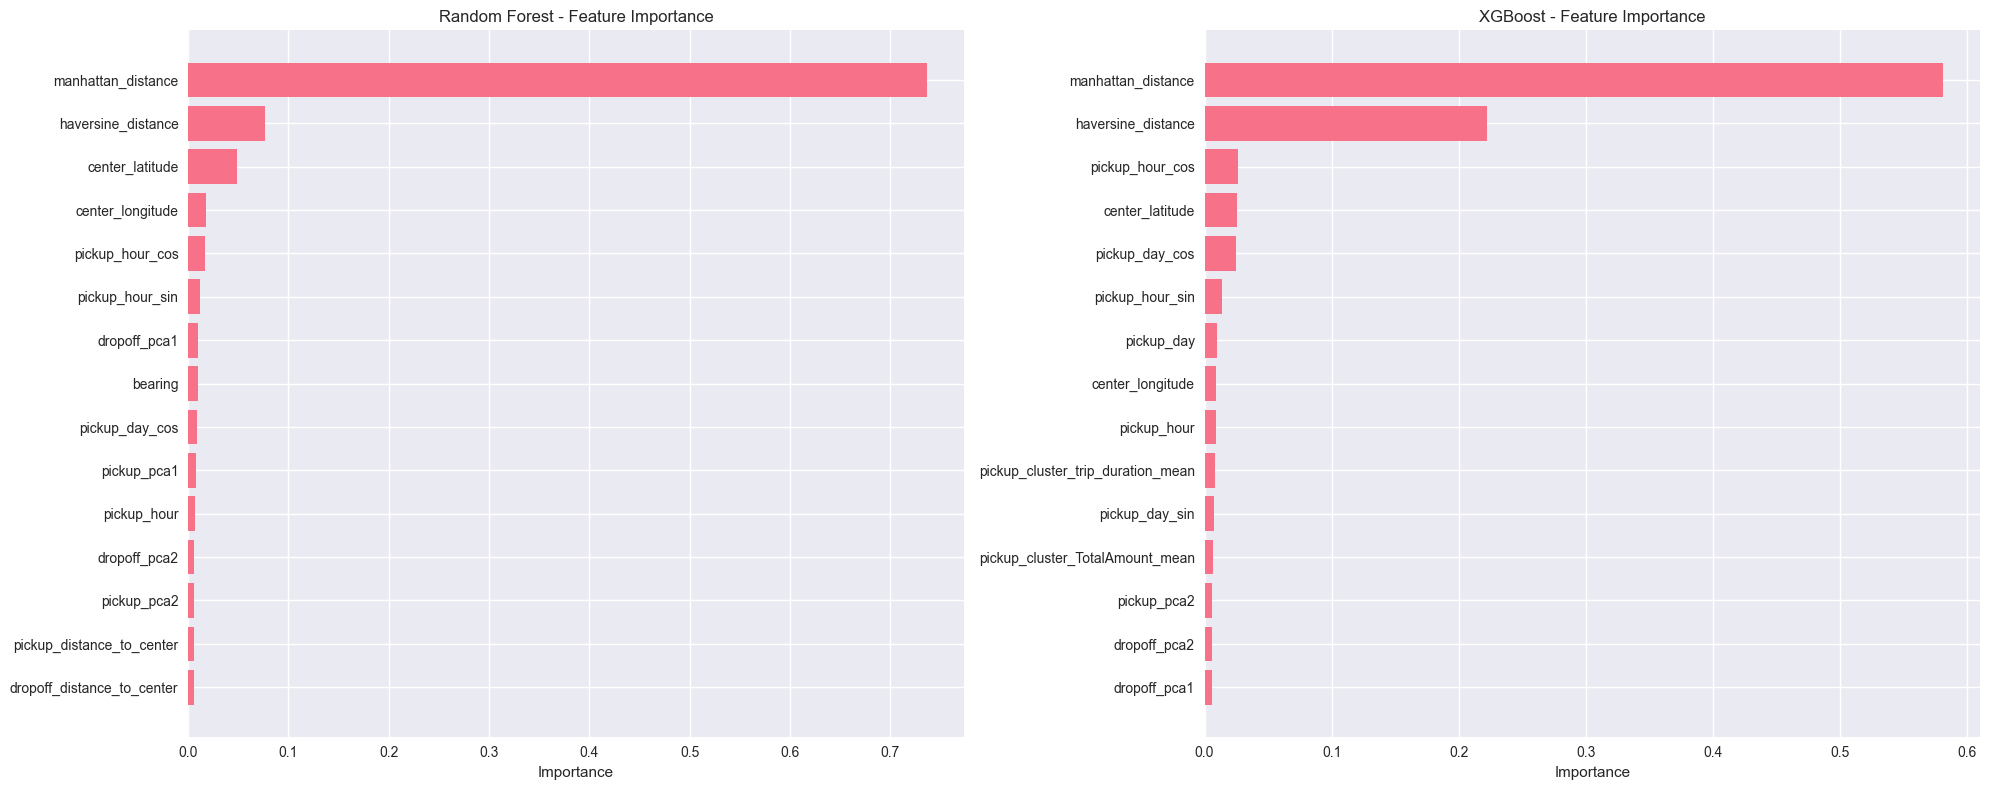

In [17]:
# Results
print(f"\nModel Performance (RMSLE):")
print(f"Random Forest: {rf_rmsle:.4f}")
print(f"XGBoost: {xgb_rmsle:.4f}")

# Feature importance
print("\nCreating feature importance plots...")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(range(len(rf_importance)), rf_importance['importance'][::-1])
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['feature'][::-1])
axes[0].set_title('Random Forest - Feature Importance')
axes[0].set_xlabel('Importance')

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(range(len(xgb_importance)), xgb_importance['importance'][::-1])
axes[1].set_yticks(range(len(xgb_importance)))
axes[1].set_yticklabels(xgb_importance['feature'][::-1])
axes[1].set_title('XGBoost - Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

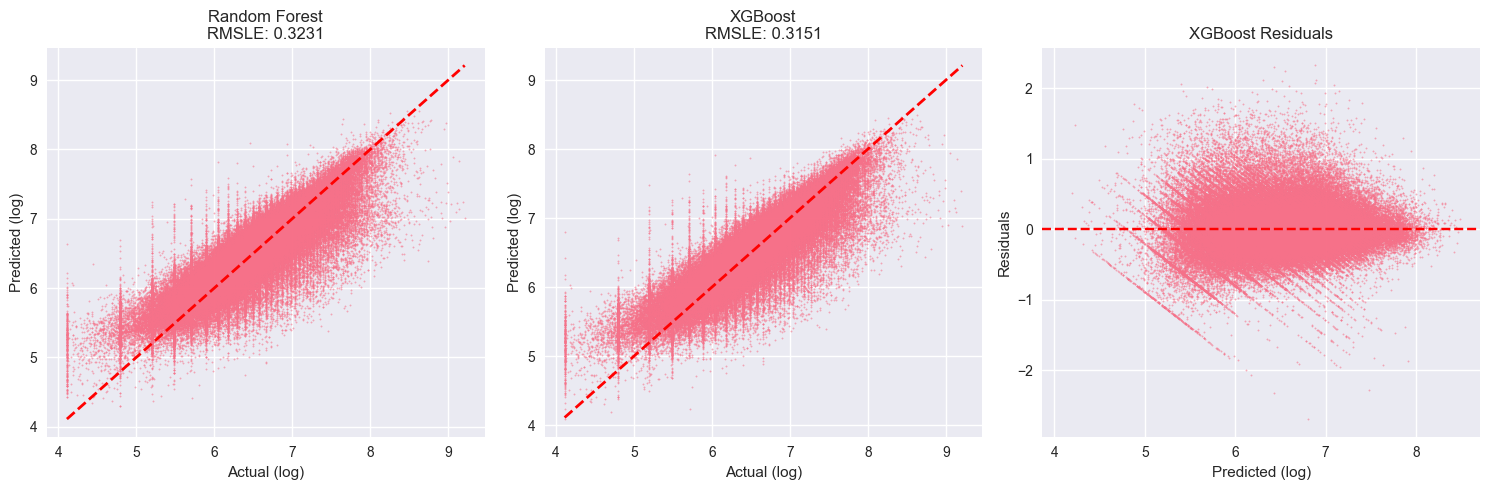


ANALYSIS COMPLETE!
Best Model: XGBoost
Best RMSLE: 0.3151

Key Insights:
1. Rush hour patterns show clear peaks during morning and evening commute
2. Geographic clustering reveals neighborhood-specific travel patterns
3. Distance features are most important for duration prediction
4. Time-based features capture traffic variation throughout the day
5. Outlier removal significantly improved model performance


In [18]:
# Prediction vs Actual plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, rf_pred, alpha=0.5, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual (log)')
plt.ylabel('Predicted (log)')
plt.title(f'Random Forest\nRMSLE: {rf_rmsle:.4f}')

plt.subplot(1, 3, 2)
plt.scatter(y_test, xgb_pred, alpha=0.5, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual (log)')
plt.ylabel('Predicted (log)')
plt.title(f'XGBoost\nRMSLE: {xgb_rmsle:.4f}')

plt.subplot(1, 3, 3)
residuals = y_test - xgb_pred
plt.scatter(xgb_pred, residuals, alpha=0.5, s=1)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted (log)')
plt.ylabel('Residuals')
plt.title('XGBoost Residuals')

plt.tight_layout()
plt.show()


print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"Best Model: {'XGBoost' if xgb_rmsle < rf_rmsle else 'Random Forest'}")
print(f"Best RMSLE: {min(rf_rmsle, xgb_rmsle):.4f}")
print("\nKey Insights:")
print("1. Rush hour patterns show clear peaks during morning and evening commute")
print("2. Geographic clustering reveals neighborhood-specific travel patterns")
print("3. Distance features are most important for duration prediction")
print("4. Time-based features capture traffic variation throughout the day")
print("5. Outlier removal significantly improved model performance")

In [19]:
# Display final feature importance table
print("\nTop 10 Most Important Features (XGBoost):")
print(xgb_importance.head(10))


Top 10 Most Important Features (XGBoost):
                              feature  importance
9                  manhattan_distance    0.581099
8                  haversine_distance    0.222003
5                     pickup_hour_cos    0.026702
20                    center_latitude    0.025246
7                      pickup_day_cos    0.024622
4                     pickup_hour_sin    0.013842
1                          pickup_day    0.010137
21                   center_longitude    0.009175
0                         pickup_hour    0.008822
22  pickup_cluster_trip_duration_mean    0.008171
